# Прогнозирование цены

### Задача
Целевая переменная — `price`. У вас есть 7 атрибутов, и, очевидно, мы хотим, чтобы вы построили некую модель машинного обучения, которая прогнозирует цены.

1. Проведите первоначальный анализ данных, который укажет на то, как связаны атрибуты.
2. Используйте некоторые ML модели и кратко объясните свой выбор.
3. Покажите точность вашей модели и прокомментируйте результаты.
4. Представьте нам результаты и шаги, которые вы предприняли, а также некоторые критические размышления.

### Описание данных
Данные представлены в файле `sample.csv`.

### Комментарии

Определите, обучите и оцените прогнозирующую модель, которая принимает в качестве входных данных предоставленные данные. По вашему усмотрению вы можете разделить данные на наборы для обучения, тестирования. Вы можете использовать любой алгоритм по вашему выбору или сравнить несколько моделей.

Убедитесь, что решение отражает весь ваш мыслительный процесс (для каждой ячейки кода оставляйте комментарии, иначе мы не поймем, что вы хотели сделать)

### Что мы точно хотим увидеть в вашей работе?

1. **Обработка данных**: Это критически важный первый шаг, который включает в себя очистку данных, обработку пропущенных значений и преобразование категориальных данных в числовой формат. Эффективная обработка данных может значительно улучшить качество модели.

2. **Проверка выбросов и корреляций**: Удаление выбросов и обработка коррелирующих признаков помогают уменьшить шум в данных и избежать проблемы мультиколлинеарности, которая может негативно сказаться на производительности модели.

3. **Feature Selection (Выбор признаков)**: Отбор признаков, которые наиболее сильно коррелируют с целевой переменной, позволяет сократить размерность данных без значительной потери информации, что упрощает модель и может улучшить её производительность.

4. **Проверка всех подходящих моделей**: Тестирование различных моделей и оценка их производительности на тренировочных и тестовых данных по критериям MSE (Mean Squared Error) и R2 позволяют выбрать наиболее подходящую модель для задачи.

5. **GridSearchCV для выбора гиперпараметров**: Использование GridSearchCV для автоматического перебора комбинаций гиперпараметров и выбора лучшего набора значений помогает оптимизировать модель.

6. **Использование StandardScaler и MinMaxScaler**: Масштабирование признаков с помощью StandardScaler (преобразование данных к стандартному нормальному распределению) и MinMaxScaler (масштабирование данных в заданный диапазон) может быть полезно для некоторых алгоритмов, чтобы улучшить их производительность, особенно для тех, которые чувствительны к масштабу признаков, как, например, методы, основанные на градиентном спуске.

Этот процесс является итеративным и может требовать нескольких проходов с корректировкой подхода на основе полученных результатов, чтобы достигнуть оптимальной производительности модели.

In [86]:
import pandas as pd
import numpy as np
import statistics
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import t

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.metrics import r2_score, mean_squared_error as MSE

from sklearn.linear_model import LinearRegression as LR
from statsmodels.regression.linear_model import OLS
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

In [4]:
# Читаем данные
data = pd.read_csv('sample.csv')
print(data.to_string())

     loc1 loc2  para1  dow  para2    para3  para4    price
0       0   01      1  Mon    662   3000.0   3.80    73.49
1       9   99      1  Thu    340   2760.0   9.20   300.00
2       0   04      0  Mon     16   2700.0   3.00   130.00
3       4   40      1  Mon     17  12320.0   6.40   365.00
4       5   50      1  Thu    610   2117.0  10.80   357.50
5       0   03      1  Tue    483   1899.0  13.60   550.00
6       0   09      1  Mon    214   1000.0   3.00   210.00
7       7   74      1  Wed    452    330.0   3.00   366.67
8       8   89      1  Tue    130   8000.0   4.50   193.33
9       1   17      4  Fri   1004   3135.0  13.20  1400.00
10      3   34      1  Wed    374  24406.0  13.60   510.00
11      3   30      1  Thu    440   7685.0  13.60   400.00
12      2   21      1  Wed    659  18000.0  13.60   800.00
13      5   50      1  Tue    292   3037.0   6.00   400.00
14      5   59      1  Wed    733  22410.0  13.60  2200.00
15      3   30      0  Wed    269   3530.0  13.60   360.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   loc1    10000 non-null  object 
 1   loc2    10000 non-null  object 
 2   para1   10000 non-null  int64  
 3   dow     10000 non-null  object 
 4   para2   10000 non-null  int64  
 5   para3   10000 non-null  float64
 6   para4   10000 non-null  float64
 7   price   10000 non-null  float64
dtypes: float64(3), int64(2), object(3)
memory usage: 625.1+ KB


In [6]:
data.describe()

,para1,para2,para3,para4,price
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.380800,447.384000,9547.989920,8.459522,433.733056
std,3.500831,221.005861,8022.814037,4.613526,277.435947
min,0.000000,16.000000,200.000000,1.000000,50.730000
25%,1.000000,301.000000,2898.000000,4.000000,250.000000
50%,1.000000,434.000000,6447.000000,7.200000,370.000000
75%,1.000000,582.000000,15000.000000,13.600000,550.000000
max,337.000000,2554.000000,34782.000000,27.200000,5700.000000


In [7]:
# Убираем повторные записи
data.drop_duplicates(inplace=True)

In [8]:
data.duplicated().sum()

0

In [9]:
data.info()  # -107 duplicates

<class 'pandas.core.frame.DataFrame'>
Index: 9893 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   loc1    9893 non-null   object 
 1   loc2    9893 non-null   object 
 2   para1   9893 non-null   int64  
 3   dow     9893 non-null   object 
 4   para2   9893 non-null   int64  
 5   para3   9893 non-null   float64
 6   para4   9893 non-null   float64
 7   price   9893 non-null   float64
dtypes: float64(3), int64(2), object(3)
memory usage: 695.6+ KB


In [10]:
print(data.iloc[:,0].value_counts().to_string())

loc1
2    1591
0    1480
1    1178
7    1078
3     937
5     833
4     767
8     722
9     690
6     615
S       1
T       1


In [11]:
loc1_variables = {'S':10, 'T':11}
data['loc1'] = data['loc1'].replace(loc1_variables)
data['loc1'] = data['loc1'].astype(int)

In [12]:
print(data.iloc[:,0].value_counts().to_string())

loc1
2     1591
0     1480
1     1178
7     1078
3      937
5      833
4      767
8      722
9      690
6      615
10       1
11       1


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9893 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   loc1    9893 non-null   int32  
 1   loc2    9893 non-null   object 
 2   para1   9893 non-null   int64  
 3   dow     9893 non-null   object 
 4   para2   9893 non-null   int64  
 5   para3   9893 non-null   float64
 6   para4   9893 non-null   float64
 7   price   9893 non-null   float64
dtypes: float64(3), int32(1), int64(2), object(2)
memory usage: 657.0+ KB


In [14]:
print(data.iloc[:,1].value_counts().to_string())

loc2
21    497
06    449
74    328
12    265
01    241
14    234
22    225
23    208
50    204
09    192
89    189
04    180
67    167
16    166
20    164
15    161
31    160
28    149
39    145
59    142
47    139
08    137
99    133
19    133
85    130
90    127
49    127
13    126
76    123
63    118
30    118
73    113
35    112
51    108
68    108
41    108
95    107
78    107
86    104
40    101
79    101
03     99
27     94
42     90
71     88
97     88
88     87
32     86
33     82
77     81
24     79
87     78
37     76
07     75
57     75
25     73
48     70
66     68
02     63
38     62
55     61
64     59
29     59
91     58
58     57
34     53
83     50
54     50
52     49
45     48
75     46
72     46
93     45
70     45
56     44
26     43
53     43
44     43
36     43
81     40
46     40
10     39
05     38
92     37
94     35
96     35
65     34
60     31
17     28
98     25
18     24
84     24
69     15
80     11
61     10
82      9
62      5
11      2
TS      1
0C   

In [15]:
print(sorted(data.iloc[:,1].unique()))

['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '0B', '0C', '0L', '0N', '0T', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', 'S6', 'TS']


In [16]:
loc2_variables = {'0B':100, '0C':101, '0L':102, '0N':103, '0T':104, 'S6':105, 'TS':106}
data['loc2'] = data['loc2'].replace(loc2_variables)
data['loc2'] = data['loc2'].astype(int)

In [17]:
print(data.iloc[:,1].value_counts().to_string())

loc2
21     497
6      449
74     328
12     265
1      241
14     234
22     225
23     208
50     204
9      192
89     189
4      180
67     167
16     166
20     164
15     161
31     160
28     149
39     145
59     142
47     139
8      137
99     133
19     133
85     130
90     127
49     127
13     126
76     123
63     118
30     118
73     113
35     112
51     108
68     108
41     108
95     107
78     107
86     104
40     101
79     101
3       99
27      94
42      90
71      88
97      88
88      87
32      86
33      82
77      81
24      79
87      78
37      76
7       75
57      75
25      73
48      70
66      68
2       63
38      62
55      61
64      59
29      59
91      58
58      57
34      53
83      50
54      50
52      49
45      48
75      46
72      46
93      45
70      45
56      44
26      43
53      43
44      43
36      43
81      40
46      40
10      39
5       38
92      37
94      35
96      35
65      34
60      31
17      28
98      25
18   

In [18]:
# Создание DataFrame для Date of week
days = {'День_недели': data['dow'].unique()}
days = pd.DataFrame(days)

# Преобразование категориальных данных с помощью One Hot Encoding
one_hot_encoded = pd.get_dummies(days['День_недели'])
one_hot_encoded = one_hot_encoded.astype(int)

print(one_hot_encoded)

   Fri  Mon  Sat  Sun  Thu  Tue  Wed
0    0    1    0    0    0    0    0
1    0    0    0    0    1    0    0
2    0    0    0    0    0    1    0
3    0    0    0    0    0    0    1
4    1    0    0    0    0    0    0
5    0    0    1    0    0    0    0
6    0    0    0    1    0    0    0


In [19]:
encoder = OneHotEncoder()
encoded = encoder.fit_transform(days)

weekdays = encoder.transform(data['dow'].values.reshape(-1,1))
weekdays_df = pd.DataFrame(weekdays.toarray(), columns=encoder.categories_[0])
weekdays_df = weekdays_df.astype(int)

weekdays_df

C:\Users\Swift\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(


,Fri,Mon,Sat,Sun,Thu,Tue,Wed
0,0,1,0,0,0,0,0
1,0,0,0,0,1,0,0
2,0,1,0,0,0,0,0
3,0,1,0,0,0,0,0
4,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...
9888,1,0,0,0,0,0,0
9889,0,0,0,0,1,0,0
9890,0,0,0,0,0,1,0
9891,1,0,0,0,0,0,0


In [20]:
data = data.drop(columns=['dow'])

In [21]:
data = pd.concat([data.reset_index(drop=True),weekdays_df.reset_index(drop=True)], axis=1)
data

,loc1,loc2,para1,para2,para3,para4,price,Fri,Mon,Sat,Sun,Thu,Tue,Wed
0,0,1,1,662,3000.0,3.8,73.49,0,1,0,0,0,0,0
1,9,99,1,340,2760.0,9.2,300.00,0,0,0,0,1,0,0
2,0,4,0,16,2700.0,3.0,130.00,0,1,0,0,0,0,0
3,4,40,1,17,12320.0,6.4,365.00,0,1,0,0,0,0,0
4,5,50,1,610,2117.0,10.8,357.50,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9888,9,98,3,386,5000.0,12.0,460.00,1,0,0,0,0,0,0
9889,7,74,1,386,3250.0,8.0,325.00,0,0,0,0,1,0,0
9890,0,6,0,190,8856.0,5.6,133.33,0,0,0,0,0,1,0
9891,7,74,3,717,5000.0,13.6,820.00,1,0,0,0,0,0,0


In [25]:
# Проверка выбросов и корреляций:




print(f"Cреднее арифметическое:{np.mean(data['price'])}\nМедиана:{np.median(data['price'])}\nМода:{statistics.mode(data['price'])}")

Cреднее арифметическое:433.1780612554332
Медиана:370.0
Мода:400.0


In [27]:
print(f"Стандартное отклонение цен:{np.std(data['price'])}")

Стандартное отклонение цен:278.1423685162952


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


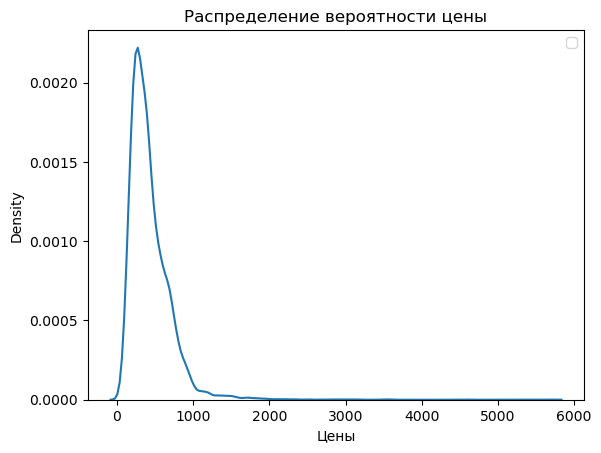

In [29]:
sns.kdeplot(data['price'])
plt.title('Распределение вероятности цены')
plt.xlabel('Цены')
plt.legend()
plt.show()

In [34]:
min_price = min(data['price'])
max_price = max(data['price'])
print(f"Размах цены:\n Min:{min_price}    Max:{max_price}    Range:{max_price-min_price}")

Размах цены:
 Min:50.73    Max:5700.0    Range:5649.27


In [77]:
q1 = np.percentile(data['price'],25)
q3 = np.percentile(data['price'],75)
h1 = np.percentile(data['price'],0)
h2 = np.percentile(data['price'],97.1)

print(f"Price IQR:{q3-q1}")


Price IQR:300.0


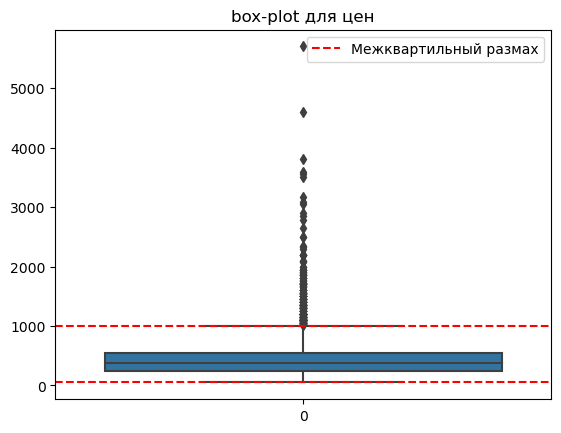

В интервалах ниже 50.73 и выше 1000.0 начинаются выбросы.


In [78]:
sns.boxplot(data['price'])
plt.title('box-plot для цен')
plt.axhline(h1, color='red', linestyle='--', label = 'Межквартильный размах')
plt.axhline(h2, color='red', linestyle='--')
plt.legend(loc=1)
plt.show()

print(f"В интервалах ниже {h1} и выше {h2} начинаются выбросы.")

In [79]:
# Убираем выбросы

data = data[(data['price']<=1000)&(data['price']>=50)] # Удалили 253 строк в виде выбросов
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9640 entries, 0 to 9892
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   loc1    9640 non-null   int32  
 1   loc2    9640 non-null   int32  
 2   para1   9640 non-null   int64  
 3   para2   9640 non-null   int64  
 4   para3   9640 non-null   float64
 5   para4   9640 non-null   float64
 6   price   9640 non-null   float64
 7   Fri     9640 non-null   int32  
 8   Mon     9640 non-null   int32  
 9   Sat     9640 non-null   int32  
 10  Sun     9640 non-null   int32  
 11  Thu     9640 non-null   int32  
 12  Tue     9640 non-null   int32  
 13  Wed     9640 non-null   int32  
dtypes: float64(3), int32(9), int64(2)
memory usage: 790.8 KB


Text(0.5, 1.0, 'QQ plot цен')

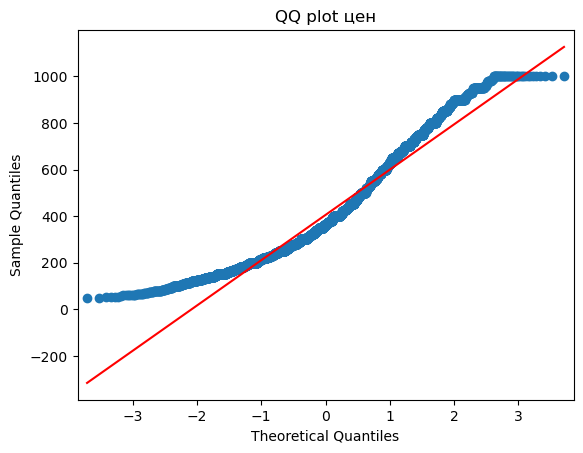

In [80]:
sm.qqplot(data['price'],line='r')
plt.title('QQ plot цен')

In [83]:
mean = np.mean(data['price'])
std = np.std(data['price'])

data.iloc[:,6] = data['price'] - mean
data.iloc[:,6] = data['price']/std
print(f"Mean:{data['price'].mean()}; Std:{data['price'].std()}")

Mean:-2.395501961846811e-17; Std:1.0000518712555793


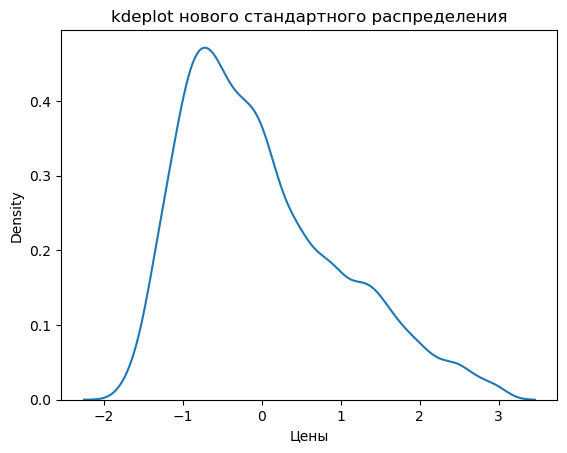

In [84]:
sns.kdeplot(data['price'])
plt.title('kdeplot нового стандартного распределения')
plt.xlabel('Цены')
plt.show()

In [87]:
p1 = norm.ppf(0.01,data['price'].mean(),data['price'].std())
print(f"Точка слева от которой будет 1% всей вероятности распределения:{p1}")

Точка слева от которой будет 1% всей вероятности распределения:-2.3264685446259814


In [89]:
data['price']

0      -1.661326
1      -0.526939
2      -1.378318
3      -0.201412
4      -0.238973
          ...   
9888    0.274358
9889   -0.401737
9890   -1.361641
9891    2.077277
9892   -0.151331
Name: price, Length: 9640, dtype: float64

In [99]:
X = data.drop(columns='price')
y = data['price'].copy()

scaler_1 = MinMaxScaler()
X_scaled_data_1 = scaler_1.fit_transform(X)
X_scaled_1 = pd.DataFrame(X_scaled_data_1, columns=X.columns)

In [100]:
X_scaled_1

,loc1,loc2,para1,para2,para3,para4,Fri,Mon,Sat,Sun,Thu,Tue,Wed
0,0.000000,0.009434,0.041667,0.340538,0.080967,0.106870,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.818182,0.933962,0.041667,0.170796,0.074027,0.312977,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.000000,0.037736,0.000000,0.000000,0.072292,0.076336,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.363636,0.377358,0.041667,0.000527,0.350471,0.206107,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.454545,0.471698,0.041667,0.313126,0.055433,0.374046,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9635,0.818182,0.924528,0.125000,0.195045,0.138801,0.419847,1.0,0.0,0.0,0.0,0.0,0.0,0.0
9636,0.636364,0.698113,0.041667,0.195045,0.088196,0.267176,0.0,0.0,0.0,0.0,1.0,0.0,0.0
9637,0.000000,0.056604,0.000000,0.091724,0.250304,0.175573,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9638,0.636364,0.698113,0.125000,0.369531,0.138801,0.480916,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [101]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_scaled_1)
X_pca



array([[-0.31067795, -0.41332566,  0.78118903, ...,  0.12909379,
        -0.00097318, -0.00973898],
       [-0.11526245, -0.19043074, -0.27429818, ..., -0.06307102,
        -0.0029072 ,  0.00194958],
       [-0.30683922, -0.4112203 ,  0.78089932, ..., -0.21387381,
        -0.00201564, -0.0247932 ],
       ...,
       [-0.36706262,  0.79579752,  0.11361742, ..., -0.11798605,
        -0.00215456, -0.03012502],
       [-0.16419207, -0.27986336, -0.72812217, ...,  0.12484212,
        -0.00388229,  0.00364602],
       [-0.14290893, -0.21423507, -0.2381763 , ...,  0.09340434,
        -0.00238433, -0.0116782 ]])

In [102]:
pca.explained_variance_ratio_

array([0.20905848, 0.19040215, 0.18605305, 0.18409056, 0.13958959,
       0.06666907, 0.01131298, 0.01007814, 0.00120769, 0.00077251])

In [103]:
scaler_2 = StandardScaler()
X_scaled_data_2 = scaler_2.fit_transform(X_pca)
X_scaled_2 = pd.DataFrame(X_scaled_data_2, columns = [i+1 for i in range(len(pca.explained_variance_ratio_))])
X_scaled_2

,1,2,3,4,5,6,7,8,9,10
0,-0.665565,-0.927834,1.773992,-0.629404,-0.708150,-1.348201,-0.359928,1.259590,-0.027430,-0.343222
1,-0.246927,-0.427479,-0.622900,1.973193,1.786004,-0.035585,1.241409,-0.615395,-0.081943,0.068707
2,-0.657341,-0.923108,1.773334,-0.613865,-0.672596,-1.421265,-0.592318,-2.086803,-0.056813,-0.873765
3,-0.557567,-0.832052,1.630627,-0.581176,0.463501,0.012490,-1.016485,-2.156690,0.023813,0.577424
4,-0.396771,-0.532242,-0.410719,1.913190,0.311028,-0.322356,1.796121,0.923552,-0.116940,-0.345562
...,...,...,...,...,...,...,...,...,...,...
9635,-0.275514,-0.577002,-1.759992,-1.046000,1.667505,0.407593,1.735613,-0.554173,-0.072373,0.600366
9636,-0.319980,-0.480788,-0.517691,1.944733,1.046528,-0.267726,0.809181,-0.292355,-0.070193,-0.045085
9637,-0.786358,1.786408,0.258012,-0.157904,-1.273749,-0.641004,-0.766150,-1.151210,-0.060729,-1.061670
9638,-0.351749,-0.628238,-1.653484,-1.079484,0.936600,0.357706,2.212131,1.218106,-0.109427,0.128494


In [104]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled_2, y, test_size=0.3, random_state=21)

In [105]:
#1 LinearRegression

model_1 = LR()
model_1.fit(X_train,y_train)
prediction_1 = model_1.predict(X_test)

print(f"MSE:{MSE(y_test, prediction_1)}")
print(f"R2:{r2_score(y_test, prediction_1)}")


# Проверка недообучения и переобучения
train_prediction_1 = model_1.predict(X_train)
print(f"MSE (train):{MSE(y_train, train_prediction_1)}")

MSE:0.43919161523131206
R2:0.5670231358060537
MSE (train):0.41702065638561336


In [107]:
#3 DecisionTreeRegressor

model_3 = DecisionTreeRegressor(max_depth=8, max_features=4, random_state=21)
model_3.fit(X_train,y_train)
prediction_3 = model_3.predict(X_test)

print(f"MSE:{MSE(y_test, prediction_3)}")
print(f"R2:{r2_score(y_test, prediction_3)}")


# Проверка недообучения и переобучения
train_prediction_3 = model_3.predict(X_train)
print(f"MSE (train):{MSE(y_train, train_prediction_3)}")

MSE:0.472855751229287
R2:0.5338353618716059
MSE (train):0.30352838667768595


In [30]:
params = {'max_depth': [3,4,5,6,7,8,9,10],
         'max_features':[2,3,4,'sqrt']}

model_3_search = GridSearchCV(cv=3, scoring='neg_mean_squared_error',estimator = model_3, param_grid=params)
model_3_search.fit(X_train, y_train)

prediction_search = model_3_search.predict(X_test)
model_3_search.best_estimator_

DecisionTreeRegressor(max_depth=8, max_features=4, random_state=21)

In [108]:
#4 RandomForestRegressor

model_4 = RandomForestRegressor(n_estimators=200, max_depth=8, max_features=4, random_state=21)
model_4.fit(X_train,y_train)
prediction_4 = model_4.predict(X_test)

print(f"MSE:{MSE(y_test, prediction_4)}")
print(f"R2:{r2_score(y_test, prediction_4)}")


# Проверка недообучения и переобучения
train_prediction_4 = model_4.predict(X_train)
print(f"MSE (train):{MSE(y_train, train_prediction_4)}")

MSE:0.3686526244697471
R2:0.636563969383358
MSE (train):0.24512490673319037


In [32]:
params = {'n_estimators': [100,150,200], 
         'max_depth': [3,4,5,6,7,8],
         'max_features':[2,3,4,'sqrt']}

model_4_search = GridSearchCV(cv=3, scoring='neg_mean_squared_error',estimator = model_4, param_grid=params)
model_4_search.fit(X_train, y_train)

prediction_search = model_4_search.predict(X_test)
model_4_search.best_estimator_

KeyboardInterrupt: 

In [109]:
#5 SVR

model_5 = SVR(kernel='poly', degree=1, C=4)
model_5.fit(X_train,y_train)
prediction_5 = model_5.predict(X_test)

print(f"MSE:{MSE(y_test, prediction_5)}")
print(f"R2:{r2_score(y_test, prediction_5)}")


# Проверка недообучения и переобучения
train_prediction_5 = model_5.predict(X_train)
print(f"MSE (train):{MSE(y_train, train_prediction_5)}")

MSE:0.44413246669130074
R2:0.5621521995281211
MSE (train):0.42102442095003173


In [ ]:
params = {'degree': [1,2,3,4,5,6], 
         'C': [0.5,0.75,1,2,3,4]
         }
model_5_search = GridSearchCV(cv=3, scoring='neg_mean_squared_error',estimator = model_5, param_grid=params)
model_5_search.fit(X_train, y_train)

prediction_search = model_5_search.predict(X_test)
model_5_search.best_estimator_

In [110]:
#6 KNeighborsRegressor

model_6 = KNeighborsRegressor(n_neighbors = 6)
model_6.fit(X_train,y_train)
prediction_6 = model_6.predict(X_test)

print(f"MSE:{MSE(y_test, prediction_6)}")
print(f"R2:{r2_score(y_test, prediction_6)}")


# Проверка недообучения и переобучения
train_prediction_6 = model_6.predict(X_train)
print(f"MSE (train):{MSE(y_train, train_prediction_6)}")

MSE:0.4033946996297149
R2:0.6023135095916092
MSE (train):0.2766752567920352


In [ ]:
params = {'n_neighbors': [2,3,4,5,6] 
         }
model_6_search = GridSearchCV(cv=3, scoring='neg_mean_squared_error',estimator = model_6, param_grid=params)
model_6_search.fit(X_train, y_train)

prediction_search = model_6_search.predict(X_test)
model_6_search.best_estimator_

6:0.392399086232627
8:0.2855303242221702
7:0.11474955713355413
9:0.06806565822688622
10:0.05236997084503128
5:0.023494850570467175
4:0.019418920805305512
3:0.016878606048216428
1:0.016059338384992322
2:0.011033687530749767


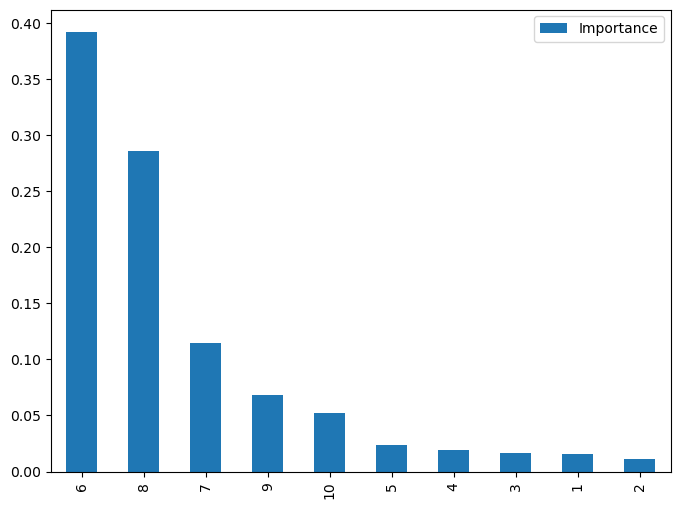

In [111]:
# Анализ корреляций между признаками
import matplotlib.pyplot as plt


importance_dict = {i+1: model_4.feature_importances_[i] for i in range(len(model_4.feature_importances_))}
importance_dict = sorted(importance_dict.items(), reverse=True, key=lambda x: x[1])

for x,y in importance_dict:
    print(f"{x}:{y}")

    
feat_importance = pd.DataFrame(model_4.feature_importances_, index=[i+1 for i in range(len(model_4.feature_importances_))], columns=['Importance'])
feat_importance.sort_values(ascending=False, by='Importance', inplace=True)
feat_importance.plot(kind='bar', figsize=(8,6))
plt.show()